In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from tensorflow.keras import metrics, optimizers, Sequential, activations, callbacks
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
import keras.backend as K
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Getting the data

In [ ]:
train_dir = '/content/drive/MyDrive/Train_Alphabet'
test_dir = '/content/drive/MyDrive/Test_Alphabet'

In [ ]:
def load_df(dir_path):
    df = {
        'filename': [],
        'label': []
    }
    classes = os.listdir(dir_path)
    for c in classes:
        path = dir_path + '/' + c

        img_paths = os.listdir(path)

        for img_path in img_paths:
            df['filename'].append(c + '/' + img_path)
            df['label'].append(c)

    df = pd.DataFrame(df)
    return df

train_df = load_df(train_dir)
test_df = load_df(test_dir)

In [ ]:
train_df.sample(5)

,filename,label
3821,A/f7338fce-d011-43f7-b576-b9c823638040.rgb_000...,A
2839,J/fe7baa53-68bd-4c89-bf8d-51873ebcec2a.rgb_000...,J
1432,T/e9452ec3-7349-432c-85f3-e2899443f579.rgb_000...,T
1871,M/de283999-97fe-4b87-8f2a-c51c17c957f7.rgb_000...,M
4072,Blank/f35c7bdc-e50c-45a5-a9c2-8c7f1c225b11.rgb...,Blank


In [ ]:
train_df['label'].value_counts()

label
N        161
U        161
Blank    160
L        159
A        159
C        159
F        159
B        159
E        159
G        159
K        159
J        159
H        159
I        159
R        159
S        159
P        159
O        159
T        159
V        159
Z        159
Y        159
W        159
X        159
D        159
M        158
Q        158
Name: count, dtype: int64

# Visualize sample files

In [ ]:
def show_img(path, row):
    filename = list(row['filename'])[0]
    label = list(row['label'])[0]
    image = cv2.imread(path + '/' + filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')
    plt.show()

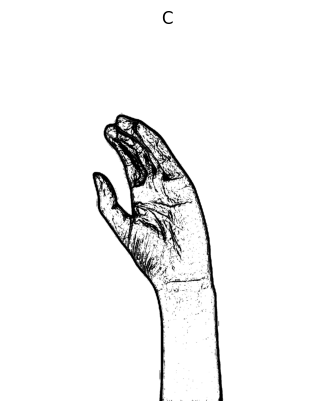

In [ ]:
show_img(train_dir, train_df.sample(1))

# Split train-valid

In [ ]:
X = train_df['filename']
y = train_df['label']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, random_state=1, test_size=0.2)
print(X_train.shape)
print(X_valid.shape)

(3436,)
(860,)


In [ ]:
train = pd.concat([X_train, y_train], axis=1)
valid = pd.concat([X_valid, y_valid], axis=1)
test = test_df

In [ ]:
IMAGE_SIZE = (224, 224)

datagen = ImageDataGenerator(
    rescale=1./255,
#     rotation_range=40,
    zoom_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
#     brightness_range=[0.5, 1.0],
)

train_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = train_dir,
    x_col='filename',
    y_col='label',
    batch_size=32,
    # color_mode="rgb",
    seed=42,
    shuffle=True,
    class_mode='sparse',
    target_size=IMAGE_SIZE
)

valid_generator=datagen.flow_from_dataframe(
    dataframe=valid,
    directory=train_dir,
    x_col="filename",
    y_col="label",
    batch_size=32,
    # color_mode="rgb",
    seed=42,
    shuffle=True,
    class_mode="sparse",
    target_size=IMAGE_SIZE
)

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=test_dir,
    x_col="filename",
    y_col=None,
    batch_size=1,
    # color_mode="rgb",
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=IMAGE_SIZE
)

Found 3436 validated image filenames belonging to 27 classes.
Found 860 validated image filenames belonging to 27 classes.
Found 1054 validated image filenames.


# Modelling

## ResNetV250

### Trained with 20 epochs

In [ ]:
cb = [callbacks.ModelCheckpoint('model_resnet.hdf5', save_best_only=True, monitor='val_loss')]

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
n_class = 27

base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable = False

inputs = Input(shape=IMAGE_SIZE + (3,), name='input_layer')
out = base_model(inputs, training=False)
out = GlobalAveragePooling2D()(out)
out = Dense(128, activation='relu')(out)
# out = Dropout(0.2)(out)
out = Dense(n_class, activation='softmax', name='output_layer')(out)
model_resnet = keras.Model(inputs, out)

model_resnet.compile(loss='sparse_categorical_crossentropy',
                     optimizer=optimizers.Adamax(learning_rate=1e-4),
                     metrics=['accuracy'])

model_resnet.summary()

94668760/94668760 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048   23564800  
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 output_layer (Dense)        (None, 27)                3483      
                                                              

In [ ]:
history_resnet = model_resnet.fit(train_generator, epochs=20,
                                  validation_data=valid_generator,
                                  batch_size=128,
                                  callbacks=cb)

Epoch 1/20
108/108 [==============================] - 3565s 33s/step - loss: 3.1793 - accuracy: 0.1196 - val_loss: 2.8162 - val_accuracy: 0.2233
Epoch 2/20
108/108 [==============================] - 890s 8s/step - loss: 2.5650 - accuracy: 0.3050 - val_loss: 2.3417 - val_accuracy: 0.3698
Epoch 3/20
108/108 [==============================] - 880s 8s/step - loss: 2.1325 - accuracy: 0.4444 - val_loss: 1.9347 - val_accuracy: 0.5116
Epoch 4/20
108/108 [==============================] - 883s 8s/step - loss: 1.7983 - accuracy: 0.5597 - val_loss: 1.6597 - val_accuracy: 0.6093
Epoch 5/20
108/108 [==============================] - 869s 8s/step - loss: 1.5372 - accuracy: 0.6481 - val_loss: 1.4475 - val_accuracy: 0.6407
Epoch 6/20
108/108 [==============================] - 880s 8s/step - loss: 1.3470 - accuracy: 0.6950 - val_loss: 1.3000 - val_accuracy: 0.6965
Epoch 7/20
108/108 [==============================] - 881s 8s/step - loss: 1.1933 - accuracy: 0.7366 - val_loss: 1.1400 - val_accuracy: 0.74

In [ ]:
history_resnet_temp = history_resnet

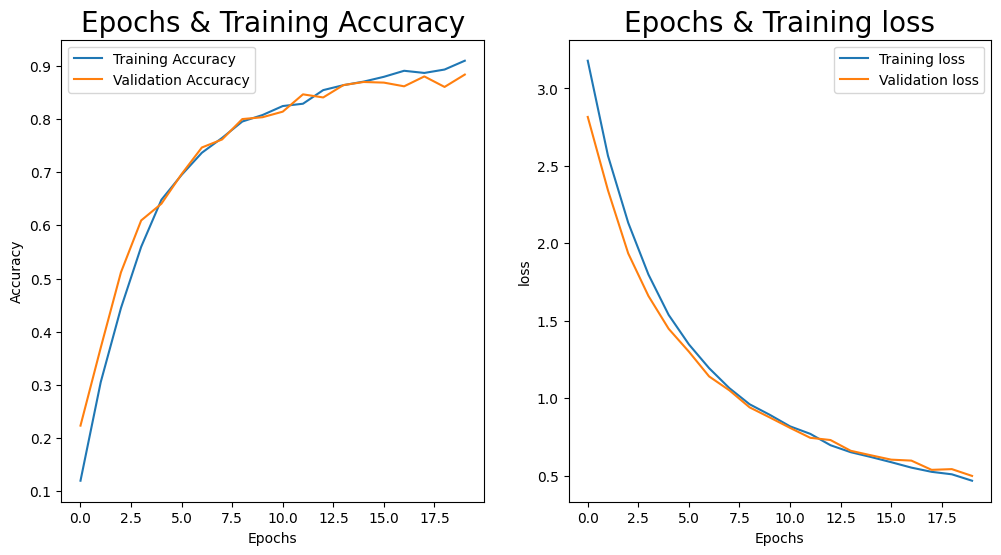

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

ax[0].plot(history_resnet_temp.history['accuracy'], '-', label = 'Training Accuracy')
ax[0].plot(history_resnet_temp.history['val_accuracy'], '-', label = 'Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize=20)
ax[0].legend(loc='best')

ax[1].plot(history_resnet_temp.history['loss'], '-', label = 'Training loss')
ax[1].plot(history_resnet_temp.history['val_loss'], '-', label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & Training loss', fontsize=20)
ax[1].legend(loc='best')

plt.show()

> The model seems to perform well, and it was a good-fit, but it could've more accuracy by adding more epochs.

In [ ]:
test_generator.reset()
pred_resnet = model_resnet.predict(test_generator, verbose=1)

1054/1054 [==============================] - 789s 747ms/step


In [ ]:
pred_resnet = np.argmax(pred_resnet,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_resnet = [labels[k] for k in pred_resnet]

In [ ]:
accuracy_score(test['label'], pred_resnet)

0.9089184060721063

In [ ]:
print(classification_report(test['label'], pred_resnet))

              precision    recall  f1-score   support

           A       0.97      0.92      0.95        39
           B       0.97      0.95      0.96        39
       Blank       1.00      1.00      1.00        39
           C       1.00      0.85      0.92        39
           D       0.83      0.87      0.85        39
           E       0.82      0.69      0.75        39
           F       0.97      0.90      0.93        39
           G       0.97      0.90      0.93        39
           H       0.95      0.95      0.95        39
           I       0.86      0.97      0.92        39
           J       0.93      0.95      0.94        39
           K       0.90      0.97      0.94        39
           L       1.00      0.92      0.96        39
           M       0.71      0.69      0.70        39
           N       0.84      0.92      0.88        39
           O       0.88      0.97      0.93        39
           P       0.93      1.00      0.96        39
           Q       1.00    

In [ ]:
model_resnet.save('resnet50v2_20_ep.hdf5')